In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from datatest import validate

# Cardiovascular Disease Risk Prediction using Random Forests

## Data Acquisition

In [10]:
# data was cleaned in previous notebook

cvd_data = pd.read_csv('preprocessedFramingham.csv')
cvd_data.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0.0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2,0,0.0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,1,20.0,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3,1,30.0,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3,1,23.0,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [11]:
cvd_data = cvd_data[['age', 'sysBP', 'diaBP', 'BMI', 'glucose', 'totChol', 'heartRate', 'TenYearCHD']]

In [12]:
print("The dimeansions of our dataset is:\n",
     cvd_data.shape)

The dimeansions of our dataset is:
 (3658, 8)


In [13]:
features = np.array(cvd_data.iloc[:,:-1].columns)
features

array(['age', 'sysBP', 'diaBP', 'BMI', 'glucose', 'totChol', 'heartRate'],
      dtype=object)

In [14]:
target = cvd_data.iloc[:,-1:].columns
target

Index(['TenYearCHD'], dtype='object')

## Checking for class imbalance

In [15]:
def class_imbalance(df, col):   
    
    counts = df[col].value_counts().reset_index()

    f = lambda x, y: (x / sum(y)) * 100

    for i in range(0, len(counts['index'])):
        print('{0} accounts for {1:.2f}% of the {2} column'\
             .format(counts['index'][i],
                    f(counts[col].iloc[i], counts[col]),
                    col))    

In [16]:
class_imbalance(cvd_data, 'TenYearCHD')        

0 accounts for 84.77% of the TenYearCHD column
1 accounts for 15.23% of the TenYearCHD column


N.B Random Forests frequently perform well on imbalanced data

## Creating the Training and Test Sets

In [17]:
df = cvd_data
target_space = np.array(df['TenYearCHD'])
target_space

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
feature_space = df.drop('TenYearCHD', axis=1)
feature_space.head()

,age,sysBP,diaBP,BMI,glucose,totChol,heartRate
0,39,106.0,70.0,26.97,77.0,195.0,80.0
1,46,121.0,81.0,28.73,76.0,250.0,95.0
2,48,127.5,80.0,25.34,70.0,245.0,75.0
3,61,150.0,95.0,28.58,103.0,225.0,65.0
4,46,130.0,84.0,23.10,85.0,285.0,85.0


In [19]:
training_set, test_set, training_target, test_target = train_test_split(feature_space,
                                                                       target_space,
                                                                       test_size = 0.30,
                                                                       random_state=42)

## Fitting the Random Forest model

In [20]:
#Instantiating the random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model

RandomForestClassifier(random_state=42)

"Parameter and hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model."

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## Optimising the parameters

In [21]:
def opt_params(rf_model, training_set, training_target):
    
    np.random.seed(42)

    parameters = {'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40],
                  'bootstrap': [True, False],
                  'max_features': ['sqrt', 'log2', None]}

    cv_rf = GridSearchCV(rf_model, cv=10,
                        param_grid=parameters,
                        n_jobs=3)

    cv_rf.fit(training_set, training_target)

    means = cv_rf.cv_results_['mean_test_score']
    stds = cv_rf.cv_results_['std_test_score']
    parameters = cv_rf.cv_results_['params']

    for mean, std, params in zip(means, stds, parameters):
        print("%0.3f (+/-%0.03f) for %r"
             % (mean, std*2, params))

    print()

    print('Best Parameters using grid search: \n %r \n best_score: %0.3f'
         % (cv_rf.best_params_, cv_rf.best_score_))

"According to the paper “Theoretical comparison between the Gini Index and Information Gain criteria” [3], the frequency of agreement/disagreement of the Gini Index and the Information Gain was only 2% of all cases, so for all intents and purposes you can pretty much use either, but the only difference is entropy might be a little slower to compute because it requires you to compute a logarithmic function. 

Many of the researchers point out that in most of the cases, the choice of splitting criteria will not make much difference in the tree performance. Each criterion is superior in some cases and inferior in others, as the “No Free Lunch” theorem suggests."

NB criterion: string, optional (default=”gini”)



"Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

Every time there is a split, your algorithm looks at a number of features and takes the one with the optimal metric using gini impurity or entropy, and creates two branches according to that feature. It is computationally heavy to look at all the features every single time, so you can just check some of them using the various max_features options. Another use of max_features is to limit overfitting, by choosing a reduced number of features we can increase the stability of the tree and reduce variance and over-fitting.

As for among the options which one to pick, it will depend on the number of features you have, the computational intensity you want to reduce or the amount of overfitting you have, so if you have a high computational cost or you have a lot of overfitting, you can try with “log2” and depending on what that produces, you can either bring it slightly up using sqrt or take it down further using a custom float value."

Quoting from: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680



In [22]:
opt_params(rf_model, training_set, training_target)

0.847 (+/-0.011) for {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt'}
0.847 (+/-0.011) for {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2'}
0.843 (+/-0.010) for {'bootstrap': True, 'max_depth': 8, 'max_features': None}
0.845 (+/-0.013) for {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt'}
0.845 (+/-0.013) for {'bootstrap': True, 'max_depth': 9, 'max_features': 'log2'}
0.843 (+/-0.012) for {'bootstrap': True, 'max_depth': 9, 'max_features': None}
0.846 (+/-0.016) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt'}
0.846 (+/-0.016) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2'}
0.841 (+/-0.015) for {'bootstrap': True, 'max_depth': 10, 'max_features': None}
0.847 (+/-0.017) for {'bootstrap': True, 'max_depth': 11, 'max_features': 'sqrt'}
0.847 (+/-0.017) for {'bootstrap': True, 'max_depth': 11, 'max_features': 'log2'}
0.840 (+/-0.016) for {'bootstrap': True, 'max_depth': 11, 'max_features': None}
0.842 (+/-0.016) for {'bootstr

In [23]:
rf_model.set_params(max_depth=8,
                   max_features='sqrt')

RandomForestClassifier(max_depth=8, max_features='sqrt', random_state=42)

## Optimising the Hyperparameters (Using Out of Bag Error Rate)

In [24]:
def opt_hyperparams(rf_model, training_set, training_target, min_est=15, max_est=1000):
    
    rf_model.set_params(warm_start=True,
                       oob_score=True)

    error_rates = {}

    for i in range(min_est, max_est+1):

        rf_model.set_params(n_estimators=i)
        rf_model.fit(training_set, training_target)

        oob_error = 1 - rf_model.oob_score_
        error_rates[i] = oob_error
        
    return error_rates

In [25]:
oob_series = pd.Series(opt_hyperparams(rf_model, training_set, training_target, 15, 1000))

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X doe

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifi

In [26]:
def plot_oob(oob_series, min_est=15, max_est=1000):

    fig, ax = plt.subplots(figsize=(10, 10))

    oob_series.plot(kind='line',
                   color='red')

    plt.xlabel('n_estimators: no of trees in a forest')
    plt.ylabel('OOB Error Rate')
    plt.title('OOB Error Rate for various tree sizes \n ({0}-{1} trees)'.format(min_est, max_est))

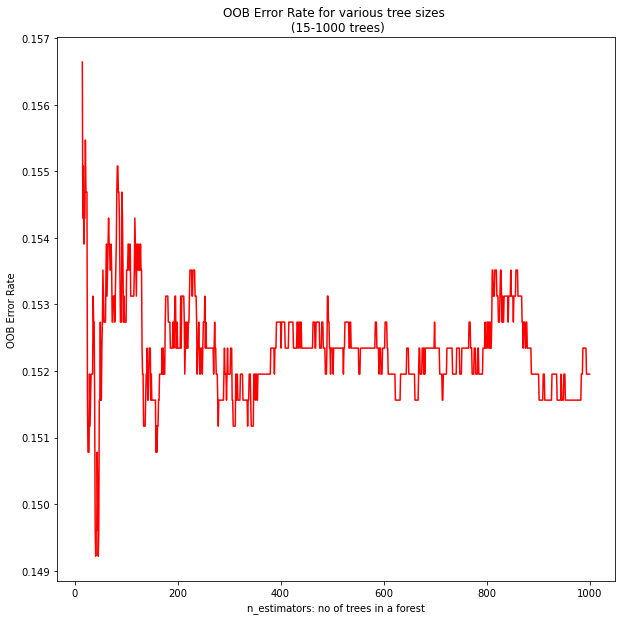

In [27]:
plot_oob(oob_series, min_est=15, max_est=1000)

The OOB error rate begins oscilate for some ranges of the numbers of trees which could be used in the forest, however it doesn't seem to get significantly better than 0.1475 throughout the continued oscillations. Therefore, 2000 trees will be used in the forest.

In [28]:
print('OOB Error rate with 2000 trees is: {0:.5f}'.format(oob_series[800]))

OOB Error rate with 2000 trees is: 0.15234


In [29]:
rf_model.set_params(n_estimators=800,
                   bootstrap=True,
                   warm_start=False,
                   oob_score=False)
                   
rf_model.fit(training_set, training_target)

RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=800,
                       random_state=42)

## Test Metrics

In [30]:
predictions_rf = rf_model.predict(test_set)

In [51]:
predictions_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Confusion Matrix

In [31]:
def create_confusion_matrix(test_target, predictions):
    
    test_crosstb = pd.crosstab(index=test_target,
                              columns=predictions).values
    
    return test_crosstb

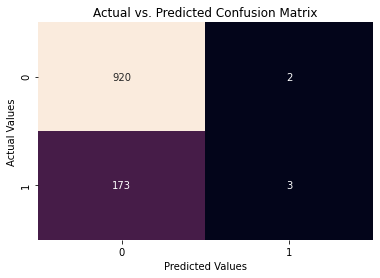

In [32]:
conf_mat = create_confusion_matrix(test_target, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

### Accuracy

In [33]:
accuracy_rf = rf_model.score(test_set, test_target)
print("The accuracy on the test set:\n {0: .3f}".format(accuracy_rf))

The accuracy on the test set:
  0.841


In [34]:
test_error_rate = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}".format(test_error_rate))

The test error rate for our model is:
  0.1594


### ROC Curve

In [35]:
prediction_prob = rf_model.predict_proba(test_set)[:,1]

fpr, tpr, _ = roc_curve(test_target,
                       prediction_prob,
                       pos_label=1)

In [36]:
auc_rf = auc(fpr, tpr)

In [37]:
def plot_roc_curve(fpr, tpr, auc, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plt.plot(fpr, tpr, color='red', linewidth = 2)
    
    plt.title("ROC Curve for Random Forest (AUC = {0: .3f})".format(auc))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    
    if xlim is not None:
        plt.xlim(*xlim)
        
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

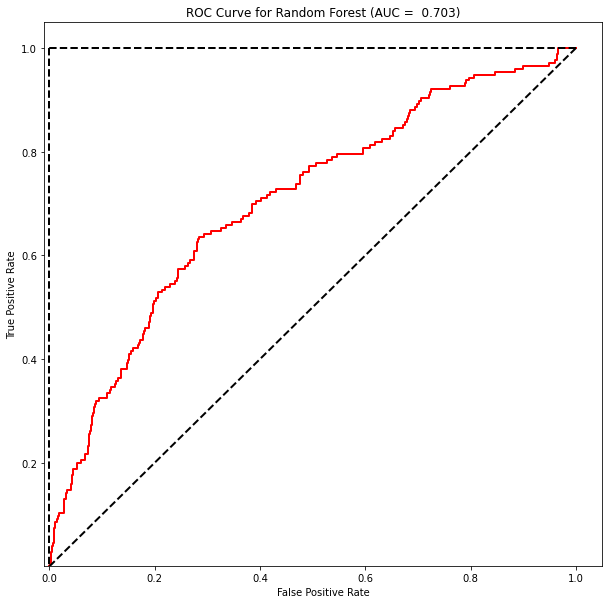

In [38]:
plot_roc_curve(fpr, tpr, auc_rf, xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

### Classification Report

In [39]:
def print_class_report(predictions, test_target):
    
    print('Classification Report for Random Forest:')
    print(classification_report(predictions, test_target, target_names=['CVD', 'No CVD']))

In [40]:
class_report = print_class_report(predictions_rf, test_target)

Classification Report for Random Forest:
              precision    recall  f1-score   support

         CVD       1.00      0.84      0.91      1093
      No CVD       0.02      0.60      0.03         5

    accuracy                           0.84      1098
   macro avg       0.51      0.72      0.47      1098
weighted avg       0.99      0.84      0.91      1098



In [41]:
len(np.argsort(rf_model.feature_importances_))

7

In [42]:
def variable_importance(model):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
           'index': indices}

In [43]:
var_imp_rf = variable_importance(rf_model)
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']

In [44]:
def print_var_importance(importance, indices, names_index):
    
    print("Feature Ranking:")
    
    for i in range(0, len(indices)):
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}".format(i+1,
                                                                                        names_index[indices[i]],
                                                                                        importance[indices[i]]))

In [45]:
print_var_importance(importances_rf, indices_rf, features)

Feature Ranking:
1. The feature 'age' has a Mean Decrease in Impurity of 0.18918
2. The feature 'sysBP' has a Mean Decrease in Impurity of 0.17641
3. The feature 'diaBP' has a Mean Decrease in Impurity of 0.14661
4. The feature 'BMI' has a Mean Decrease in Impurity of 0.14229
5. The feature 'glucose' has a Mean Decrease in Impurity of 0.12958
6. The feature 'totChol' has a Mean Decrease in Impurity of 0.12515
7. The feature 'heartRate' has a Mean Decrease in Impurity of 0.09079


In [46]:
def plot_variable_importance(importance, indices, names_index):
    
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    #ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nCVD (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center")
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 15)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

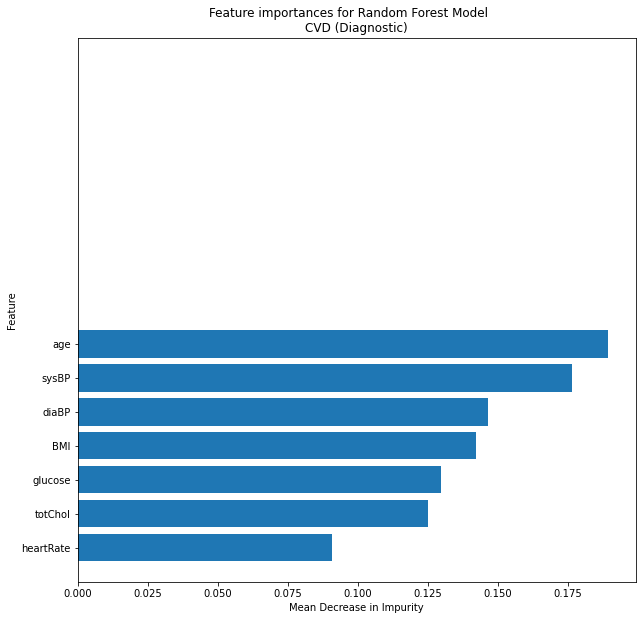

In [47]:
plot_variable_importance(importances_rf, indices_rf, list(features))

In [111]:
df = pd.DataFrame(columns = ['age', 'sysBP', 'diaBP', 'BMI', 'glucose', 'totChol', 'heartRate'])
df = df.append({'age': 61, 'sysBP': 150, 'diaBP': 95, 'BMI': 28.58, 'glucose': 103, 'totChol': 225, 'heartRate': 65}, ignore_index=True)
df

,age,sysBP,diaBP,BMI,glucose,totChol,heartRate
0,61.0,150.0,95.0,28.58,103.0,225.0,65.0


In [112]:
pre = rf_model.predict_proba(df)[:,1]*100
pre

array([45.27723867])

In [113]:
if pre[0] < 20:
    print('Patient is not at risk of developing CHD within the next 10 years')
    
elif pre[0] >= 20:
    print('Patient is at risk of developing CHD within the next 10 years')  
    

Patient is at risk of developing CHD within the next 10 years
